<a href="https://colab.research.google.com/github/JINU6497/JINUrepo/blob/master/AutoEncoder_design_by_using_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
'''1. Module Import'''
import numpy as np  # 선형대수 관련 모듈
import matplotlib.pyplot as plt  # 결과 산출물을 시각화하는 모듈

import torch
import torch.nn as nn  # 인공 신경망 모델 설계에 필요한 함수들 모아 놓은 모듈 
import torch.nn.functional as F # torch.nn 중에서도 자주 쓰이는 functional 함수들을 따로 F로 지정 
from torchvision import transforms, datasets  # Computer vision 분야에서 자주 이용되는 torchvision 내의 함수 임포트

In [18]:
'''2. 딥러닝 모델 설계에 활용하는 장비 확인'''
if torch.cuda.is_available():
  DEVICE=torch.device('cuda')
else:
  DEVICE=torch.device('cpu')

print("Using pytorch version:",torch.__version__,'Device:',DEVICE)

Using pytorch version: 1.9.0+cu102 Device: cpu


In [19]:
BATCH_SIZE = 32
EPOCHS = 10

BATCH_SIZE: AE모델을 학습할 때 필요한 데이터 개수의 단위. Mini-Batch 1개에 데이터가 32개로 구성되어 있는 것을 의미. 32개의 데이터로 1개의 Mini-Batch를 구성하고 있으며 1개의 Mini-Batch로학습을 1회 진행. 이때 1개의 Mini-Batch를 통해 학습하는 횟수를 'Iteration'이라고 하고, 전체 데이터를 이용하여 학습을 진행한 횟수를 'Epoch'라고 한다. 즉, Epoch는 존재하는 Mini-Batch를 전부 이용하는 횟수를 의미한다.

In [20]:
'''3. FashionMNIST 데이터 다운로드(Train과 Test set 분리)'''
train_dataset=datasets.FashionMNIST(root="../data/Fashion,MNIST",train=True,download=True,transform=transforms.ToTensor())
test_dataset=datasets.FashionMNIST(root="../data/Fashion,MNIST",train=False,transform=transforms.ToTensor())

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

여기서 loader의 역할은 다운로드한 FashionMNIST 데이터셋을 Mini-Batch 단위로 분리해 지정하는 것. Mini-Batch 단위를 통해 AE모델을 학습시킬 것이므로 Mini-Batch별로 데이터를 묶어 단위를 맞추려는 것

In [21]:
'''4. 데이터 확인'''
for (X_train, Y_train) in train_loader:
  print('X_train:',X_train.size(),'type:',X_train.type())
  print('Y_train:',Y_train.size(),'type:',Y_train.type())
  break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.LongTensor


X_train: 32개의 이미지 데이터가 1개의 Mini-Batch를 구성하고 있고, 가로 28개, 세로 28개의 픽셀로 구성돼 있으며 채널이 1이므로 그레이스스케일, 즉 흑백으로 이뤄진 이미지 데이터

Y_train: 32개의 이미지 데이터에 Label 값이 1개씩 존재하기 때문에 32개의 값을 지니고 있다.

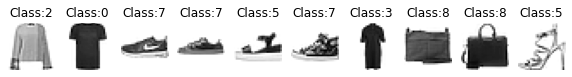

In [22]:
pltsize=1
plt.figure(figsize=(10*pltsize,pltsize))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28),cmap='gray_r')
  plt.title('Class:'+str(Y_train[i].item()))

[Mini-Batch, Channel, Height, Width]의 형태. 즉 1개의 Mini-Batch 내에는 32개의 데이터가 있고 채널이 1개이며 세로28, 가로28인 이미지 데이터를 의미하는 [32,1,28,28]데이터 모양을 사람의 눈으로 직접 확인할 수 있도록 시각화하거나 [Width, Height, Channel] 형태로 변환하기 위해 [28,28,1]로 각각 변환해 시각화

In [23]:
'''5. AutoEncoder 모델 설계'''
class AE(nn.Module):
  def __init__(self):
    super(AE,self).__init__()

    self.encoder=nn.Sequential(
        nn.Linear(28*28,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,32),
    )
    self.decoder=nn.Sequential(
        nn.Linear(32,256),
        nn.ReLU(),
        nn.Linear(256,512),
        nn.ReLU(),
        nn.Linear(512,28*28),
    )

  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

먼저 Pytorch Module 내 딥러닝 모델 관련 기본 함수를 포함하는 nn.Module 클래스를 상속받는 Net 클래스를 정의. 이후 AE 클래스의 인스턴스를 생성했을 때 지니게 되는 성질을 정의해주는 메서드를 만드는데, 이는 nn.Module 내에 있는 메서드를 상속받아서 이용한다. 이후 AutoEncoder를 nn.Sequential()을 이용해 인코더 단위 정의.


In [24]:
'''6. Optimizer, Objective Fundtion 설정'''

model=AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion=nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [25]:
'''7. AE모델 학습 진행하면서 Train데이터에 대한 모델의 성능 확인하는 함수 정의'''
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx,(image,_) in enumerate(train_loader):
    image=image.view(-1,28*28).to(DEVICE)
    target=image.view(-1,28*28).to(DEVICE)
    optimizer.zero_grad()
    encoded, decoded= model(image)
    loss = criterion(decoded, target)
    loss.backward()
    optimizer.step()

    if batch_idx %log_interval ==0:
      print("Train Epoch:{}[{}/{}({:.0f}%)]\tTrain Loss:{:.6f}".format(Epoch, batch_idx*len(image),
                                                                       len(train_loader.dataset),100.*batch_idx/len(train_loader),loss.item()))


In [28]:
'''8. 학습 과정 속에서 Test 데이터에 대한 모델 성능 확인하는 함수 정의'''

def evaluate(model, test_loader):
  model.eval()
  test_loss=0
  real_image=[]
  gen_image=[]
  with torch.no_grad():
    for image,_ in test_loader:
      image=image.view(-1,28*28).to(DEVICE)
      target=image.view(-1,28*28).to(DEVICE)
      encoded, decoded = model(image)

      test_loss += criterion(decoded, image).item()
      real_image.append(image.to("cpu"))
      gen_image.append(decoded.to("cpu"))
  
  test_loss/=len(test_loader.dataset)
  return test_loss, real_image, gen_image

학습 과정 속에서 AutoEncoder에 이용되는 실제 이미지 데이터를 리스트에 저장하기 위해 빈 리스트를 만들어주고, AutoEncoder를 통해 생성되는 이미지 데이터역시 저장하기 위해 빈 리스트를 할당해준다.

Train Epoch:1[0/60000(0%)]	Train Loss:0.015986
Train Epoch:1[6400/60000(11%)]	Train Loss:0.012460
Train Epoch:1[12800/60000(21%)]	Train Loss:0.015132
Train Epoch:1[19200/60000(32%)]	Train Loss:0.012130
Train Epoch:1[25600/60000(43%)]	Train Loss:0.015048
Train Epoch:1[32000/60000(53%)]	Train Loss:0.012385
Train Epoch:1[38400/60000(64%)]	Train Loss:0.013790
Train Epoch:1[44800/60000(75%)]	Train Loss:0.014602
Train Epoch:1[51200/60000(85%)]	Train Loss:0.011516
Train Epoch:1[57600/60000(96%)]	Train Loss:0.012865

[EPOCH:1], 	Test Loss: 0.0004


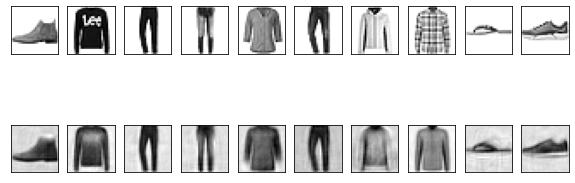

Train Epoch:2[0/60000(0%)]	Train Loss:0.012956
Train Epoch:2[6400/60000(11%)]	Train Loss:0.011757
Train Epoch:2[12800/60000(21%)]	Train Loss:0.011626
Train Epoch:2[19200/60000(32%)]	Train Loss:0.010877
Train Epoch:2[25600/60000(43%)]	Train Loss:0.011927
Train Epoch:2[32000/60000(53%)]	Train Loss:0.013060
Train Epoch:2[38400/60000(64%)]	Train Loss:0.012061
Train Epoch:2[44800/60000(75%)]	Train Loss:0.016305
Train Epoch:2[51200/60000(85%)]	Train Loss:0.012126
Train Epoch:2[57600/60000(96%)]	Train Loss:0.012608

[EPOCH:2], 	Test Loss: 0.0004


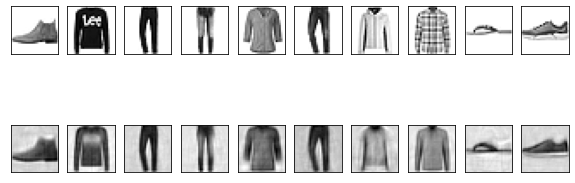

Train Epoch:3[0/60000(0%)]	Train Loss:0.011442
Train Epoch:3[6400/60000(11%)]	Train Loss:0.012203
Train Epoch:3[12800/60000(21%)]	Train Loss:0.011288
Train Epoch:3[19200/60000(32%)]	Train Loss:0.012093
Train Epoch:3[25600/60000(43%)]	Train Loss:0.011101
Train Epoch:3[32000/60000(53%)]	Train Loss:0.011278
Train Epoch:3[38400/60000(64%)]	Train Loss:0.010169
Train Epoch:3[44800/60000(75%)]	Train Loss:0.014360
Train Epoch:3[51200/60000(85%)]	Train Loss:0.013398
Train Epoch:3[57600/60000(96%)]	Train Loss:0.010942

[EPOCH:3], 	Test Loss: 0.0003


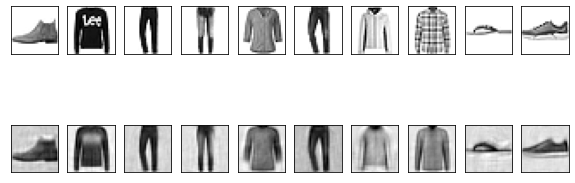

Train Epoch:4[0/60000(0%)]	Train Loss:0.010306
Train Epoch:4[6400/60000(11%)]	Train Loss:0.008933
Train Epoch:4[12800/60000(21%)]	Train Loss:0.011276
Train Epoch:4[19200/60000(32%)]	Train Loss:0.011250
Train Epoch:4[25600/60000(43%)]	Train Loss:0.009793
Train Epoch:4[32000/60000(53%)]	Train Loss:0.010290
Train Epoch:4[38400/60000(64%)]	Train Loss:0.010028
Train Epoch:4[44800/60000(75%)]	Train Loss:0.008524
Train Epoch:4[51200/60000(85%)]	Train Loss:0.013577
Train Epoch:4[57600/60000(96%)]	Train Loss:0.008253

[EPOCH:4], 	Test Loss: 0.0003


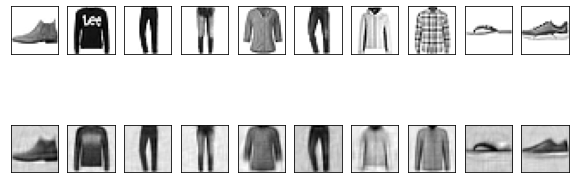

Train Epoch:5[0/60000(0%)]	Train Loss:0.008772
Train Epoch:5[6400/60000(11%)]	Train Loss:0.012278
Train Epoch:5[12800/60000(21%)]	Train Loss:0.012272
Train Epoch:5[19200/60000(32%)]	Train Loss:0.011333
Train Epoch:5[25600/60000(43%)]	Train Loss:0.011284
Train Epoch:5[32000/60000(53%)]	Train Loss:0.009426
Train Epoch:5[38400/60000(64%)]	Train Loss:0.010069
Train Epoch:5[44800/60000(75%)]	Train Loss:0.012507
Train Epoch:5[51200/60000(85%)]	Train Loss:0.010172
Train Epoch:5[57600/60000(96%)]	Train Loss:0.010194

[EPOCH:5], 	Test Loss: 0.0003


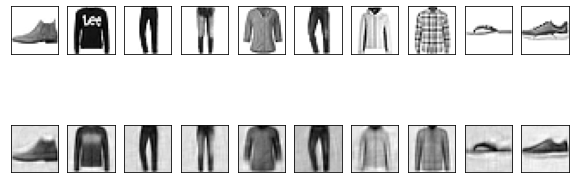

Train Epoch:6[0/60000(0%)]	Train Loss:0.011565
Train Epoch:6[6400/60000(11%)]	Train Loss:0.011780
Train Epoch:6[12800/60000(21%)]	Train Loss:0.010777
Train Epoch:6[19200/60000(32%)]	Train Loss:0.011703
Train Epoch:6[25600/60000(43%)]	Train Loss:0.011294
Train Epoch:6[32000/60000(53%)]	Train Loss:0.009506
Train Epoch:6[38400/60000(64%)]	Train Loss:0.012909
Train Epoch:6[44800/60000(75%)]	Train Loss:0.010116
Train Epoch:6[51200/60000(85%)]	Train Loss:0.008331
Train Epoch:6[57600/60000(96%)]	Train Loss:0.009720

[EPOCH:6], 	Test Loss: 0.0003


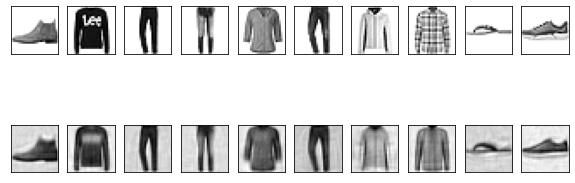

Train Epoch:7[0/60000(0%)]	Train Loss:0.010436
Train Epoch:7[6400/60000(11%)]	Train Loss:0.007606
Train Epoch:7[12800/60000(21%)]	Train Loss:0.009643
Train Epoch:7[19200/60000(32%)]	Train Loss:0.009115
Train Epoch:7[25600/60000(43%)]	Train Loss:0.008572
Train Epoch:7[32000/60000(53%)]	Train Loss:0.008210
Train Epoch:7[38400/60000(64%)]	Train Loss:0.010124
Train Epoch:7[44800/60000(75%)]	Train Loss:0.011152
Train Epoch:7[51200/60000(85%)]	Train Loss:0.008332
Train Epoch:7[57600/60000(96%)]	Train Loss:0.009433

[EPOCH:7], 	Test Loss: 0.0003


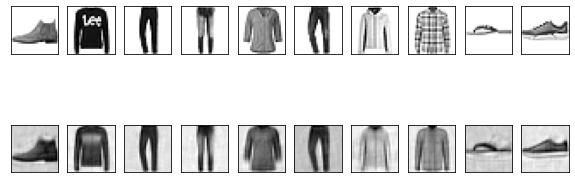

Train Epoch:8[0/60000(0%)]	Train Loss:0.008882
Train Epoch:8[6400/60000(11%)]	Train Loss:0.009089
Train Epoch:8[12800/60000(21%)]	Train Loss:0.011132
Train Epoch:8[19200/60000(32%)]	Train Loss:0.010311
Train Epoch:8[25600/60000(43%)]	Train Loss:0.009077
Train Epoch:8[32000/60000(53%)]	Train Loss:0.009956
Train Epoch:8[38400/60000(64%)]	Train Loss:0.008322
Train Epoch:8[44800/60000(75%)]	Train Loss:0.008379
Train Epoch:8[51200/60000(85%)]	Train Loss:0.008287
Train Epoch:8[57600/60000(96%)]	Train Loss:0.008104

[EPOCH:8], 	Test Loss: 0.0003


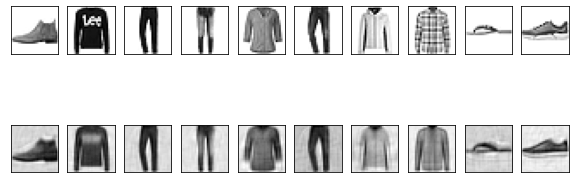

Train Epoch:9[0/60000(0%)]	Train Loss:0.010532
Train Epoch:9[6400/60000(11%)]	Train Loss:0.012649
Train Epoch:9[12800/60000(21%)]	Train Loss:0.008757
Train Epoch:9[19200/60000(32%)]	Train Loss:0.009610
Train Epoch:9[25600/60000(43%)]	Train Loss:0.010333
Train Epoch:9[32000/60000(53%)]	Train Loss:0.009159
Train Epoch:9[38400/60000(64%)]	Train Loss:0.009853
Train Epoch:9[44800/60000(75%)]	Train Loss:0.010997
Train Epoch:9[51200/60000(85%)]	Train Loss:0.008825
Train Epoch:9[57600/60000(96%)]	Train Loss:0.008988

[EPOCH:9], 	Test Loss: 0.0003


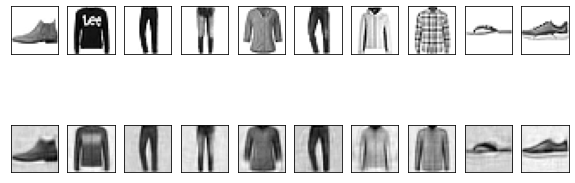

Train Epoch:10[0/60000(0%)]	Train Loss:0.010928
Train Epoch:10[6400/60000(11%)]	Train Loss:0.007571
Train Epoch:10[12800/60000(21%)]	Train Loss:0.008953
Train Epoch:10[19200/60000(32%)]	Train Loss:0.011938
Train Epoch:10[25600/60000(43%)]	Train Loss:0.007970
Train Epoch:10[32000/60000(53%)]	Train Loss:0.011156
Train Epoch:10[38400/60000(64%)]	Train Loss:0.010015
Train Epoch:10[44800/60000(75%)]	Train Loss:0.009160
Train Epoch:10[51200/60000(85%)]	Train Loss:0.009653
Train Epoch:10[57600/60000(96%)]	Train Loss:0.008462

[EPOCH:10], 	Test Loss: 0.0003


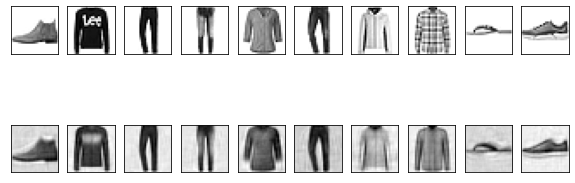

In [29]:
'''9. AutoEncoder학습을 실행하면서 Test set의 Reconstruction Error 확인'''
for Epoch in range(1,EPOCHS+1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, real_image, gen_image = evaluate(model, test_loader)
  print("\n[EPOCH:{}], \tTest Loss: {:.4f}".format(Epoch,test_loss))
  f, a = plt.subplots(2,10,figsize=(10,4))
  for i in range(10):
    img = np.reshape(real_image[0][i],(28,28))
    a[0][i].imshow(img,cmap="gray_r")
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())

  for i in range(10):
    img = np.reshape(gen_image[0][i],(28,28))
    a[1][i].imshow(img,cmap="gray_r")
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())
  plt.show()


기존에 정의한 train 함수 실행. 여기서 model은 기존에 정의한 MLP, 'train_loader'는 학습데이터, 'optimizer'는 SGD, 'log_interval'은 학습이 진행되면서 Mini-Batch의 Index를 이용하여 과정을 모니터링할 수 있도록 출력하는 것을 의미.
이후 각 Epoch별 출력되는 Loss 값과 실제 이미지, 생성된 이미지를 저장한 리스트를 생성.